# Image Segmentation by Unsupervised Learning

## import libraries

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

In [82]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2


## load data

In [83]:
directory_data  = './'
filename_data   = 'assignment_10_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

image_train     = data['image_train']
mask_train      = data['mask_train']

image_test      = data['image_test']
mask_test       = data['mask_test']

num_data_train  = image_train.shape[0]
num_data_test   = image_test.shape[0]

In [84]:
print('*************************************************')
print('size of x_train :', image_train.shape)
print('size of y_train :', mask_train.shape)
print('*************************************************')
print('size of x_test :', image_test.shape)
print('size of y_test :', mask_test.shape)
print('*************************************************')

*************************************************
size of x_train : (1000, 32, 32)
size of y_train : (1000, 32, 32)
*************************************************
size of x_test : (1000, 32, 32)
size of y_test : (1000, 32, 32)
*************************************************


## plot data

In [85]:
def plot_image(title, image, mask):
    
    nRow = 2
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
    
    for c in range(nCol):
        axes[0, c].imshow(image[c], cmap='gray')
        axes[1, c].imshow(mask[c], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

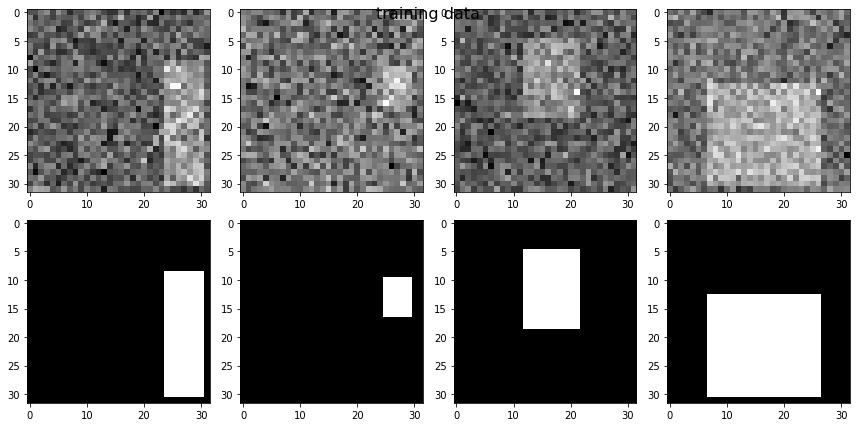

In [86]:
plot_image('training data', image_train, mask_train)

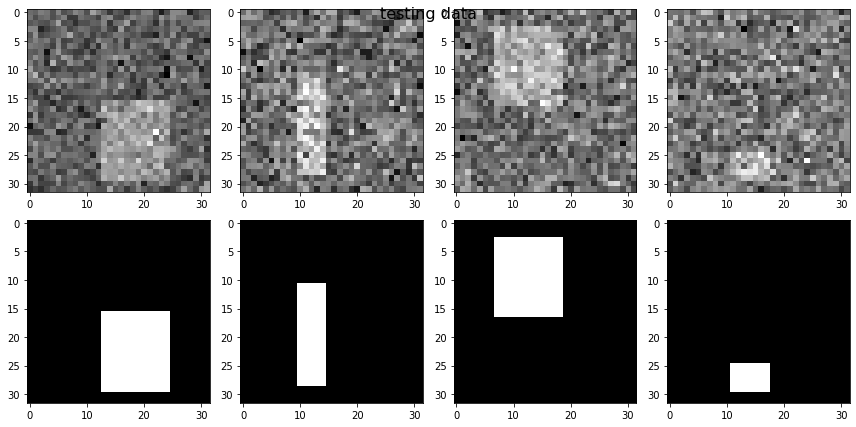

In [87]:
plot_image('testing data', image_test, mask_test)

## custom data loader for the PyTorch framework

In [88]:
class dataset(Dataset):
    
    def __init__(self, image, mask, use_transform=False):
        
        self.image          = image
        self.mask           = mask
        self.use_transform  = use_transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        mask    = self.mask[index]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        mask    = torch.FloatTensor(mask).unsqueeze(dim=0)

        # apply a data augmentation scheme
        if self.use_transform:
            # ==================================================
            # add codes for applying data augmentation 
            #

                image   = transforms.RandomRotation(degrees = 45)(image)
                mask    = transforms.RandomRotation(degrees = 45)(mask)
            
            #    
            # ==================================================

        return (image, mask)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [90]:
print(device)

cuda


## construct datasets and dataloaders for testing and testing

In [91]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 10 
#
# ==================================================

dataset_train       = dataset(image_train, mask_train, True)
dataset_test        = dataset(image_test, mask_test, False)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=False)

## construct a neural network 

In [92]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1, bias=True),  
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.decoder_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [93]:
model       = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#
learning_rate   = 0.01
alpha           = 0.001
number_epoch    = 100
optimizer       = torch.optim.SGD(model.parameters(), lr=learning_rate)
#
# ==================================================

## compute the prediction

In [94]:
def compute_prediction(model, data):

    prediction = model(data)

    return prediction

## compute the loss

In [95]:
def compute_estimate(data, prediction):
    # ==================================================
    # fill up the blank
    #
    (b, c, h, w) = data.size()
    estimate = torch.zeros(2, b, c).to(device)

    estimate[0] = torch.sum(torch.sum(data*prediction, axis=2), axis=2)/ torch.sum(torch.sum(prediction, axis=2) , axis=2)
    estimate[1] = torch.sum(torch.sum(data*(1-prediction), axis=2) ,axis=2) / torch.sum(torch.sum((1-prediction), axis=2), axis=2)

    #
    # ==================================================

    return estimate

In [96]:
def compute_loss_data_fidelity(data, prediction):
    # ==================================================
    # fill up the blank
    # 
    (b, c, h, w) = data.size()
    estimate = compute_estimate(data, prediction)
    estimate_in = torch.unsqueeze(torch.unsqueeze(estimate[0], dim = -1), dim = -1)
    estimate_out = torch.unsqueeze(torch.unsqueeze(estimate[1], dim = -1), dim = -1)
    residual_in = torch.square(data - estimate_in)
    residual_out = torch.square(data - estimate_out)
    fidelity_in = torch.sum(prediction*residual_in)
    fidelity_out = torch.sum((1-prediction)*residual_out)
    loss = (fidelity_in + fidelity_out)/(b*c*h*w)

    #
    # ==================================================

    return loss

In [97]:
def compute_loss_regularization(prediction):
    # ==================================================
    # fill up the blank
    # 
    (b, c, h, w) = prediction.size()
    gradient_yaxis = torch.abs(prediction[:,:,1:,:]- prediction[:,:,:-1,:]).sum()
    gradient_xaxis = torch.abs(prediction[:,:,:,1:]- prediction[:,:,:,:-1]).sum()
    loss = (gradient_yaxis+gradient_xaxis)/(b*c*h*w)

    #
    # ==================================================
    
    return loss

In [98]:
def compute_loss(data, prediction, alpha):
    # ==================================================
    # fill up the blank
    #

    loss_data_fidelity  = compute_loss_data_fidelity(data, prediction)
    loss_regularization = compute_loss_regularization(prediction)
    loss                = loss_data_fidelity + alpha*loss_regularization

    #
    # ==================================================

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [99]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy

In [100]:
def compute_accuracy(prediction, mask):
    
    prediction1 = prediction.squeeze(axis=1)
    prediction2 = 1 - prediction.squeeze(axis=1)
    binary1     = (prediction1 >= 0.5)
    binary2     = (prediction2 >= 0.5)
    mask        = mask.squeeze(axis=1).bool()
    
    intersection1   = (binary1 & mask).float().sum((1, 2))
    intersection2   = (binary2 & mask).float().sum((1, 2))
    union1          = (binary1 | mask).float().sum((1, 2))
    union2          = (binary2 | mask).float().sum((1, 2))

    eps         = 1e-8
    correct1    = (intersection1 + eps) / (union1 + eps)
    correct2    = (intersection2 + eps) / (union2 + eps)
    accuracy1   = correct1.mean() * 100.0
    accuracy2   = correct2.mean() * 100.0
    
    accuracy    = torch.max(accuracy1, accuracy2)
    accuracy    = accuracy.cpu() 
    
    return accuracy

## Variable for the learning curves

In [101]:
loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [102]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.train()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model, image)
        (loss, loss_data_fidelity, loss_regularization) = compute_loss(image, prediction, alpha)
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy(prediction, mask)
        #
        # ==================================================
        
        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)

        # update the model    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## test

In [103]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.eval()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model, image)
        (loss, loss_data_fidelity, loss_regularization) = compute_loss(image, prediction, alpha)
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy(prediction, mask)
        #
        # ==================================================

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## train and test

In [104]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, accuracy_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    accuracy_train_mean[i]  = accuracy_train['mean']
    accuracy_train_std[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, accuracy_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    accuracy_test_mean[i]  = accuracy_test['mean']
    accuracy_test_std[i]   = accuracy_test['std']

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


---

## functions for presenting the results

---

In [105]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [106]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [107]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [108]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [109]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [110]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [111]:
def function_result_07():
    
    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [112]:
def function_result_08():
    
    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [113]:
def function_result_09():

    nRow = 10
    nCol = 4 
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_train)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)

    image       = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_train.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):

            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [114]:
def function_result_10():
    
    nRow = 10
    nCol = 4 
    size = 3 

    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_test)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)
    
    image       = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_test.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):
    
            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [115]:
def function_result_11():
    
    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [116]:
def function_result_12():
    
    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



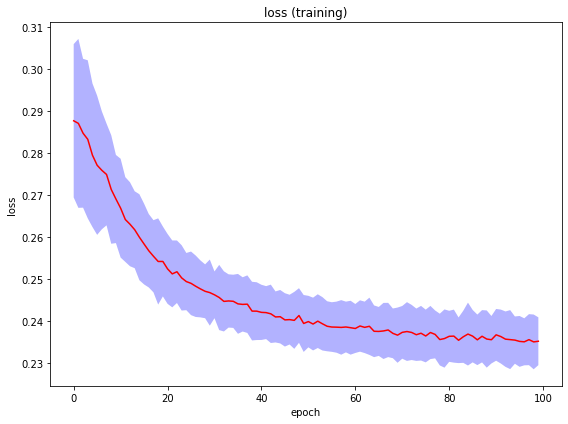


################################################################################
#
# RESULT # 02
#
################################################################################



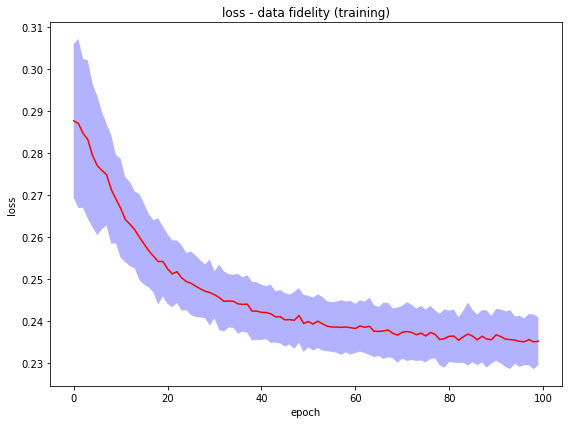


################################################################################
#
# RESULT # 03
#
################################################################################



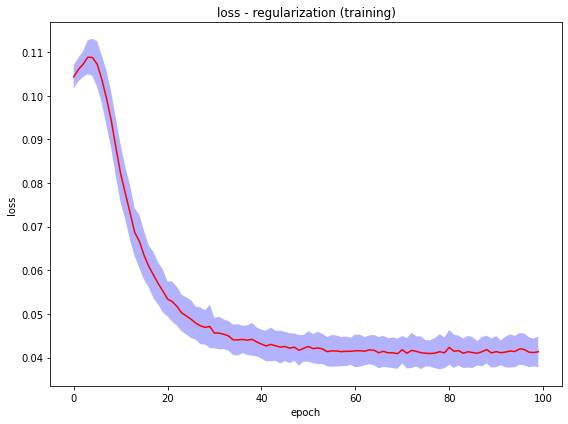


################################################################################
#
# RESULT # 04
#
################################################################################



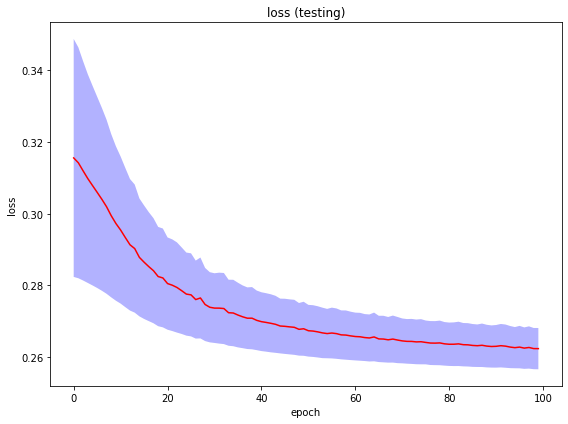


################################################################################
#
# RESULT # 05
#
################################################################################



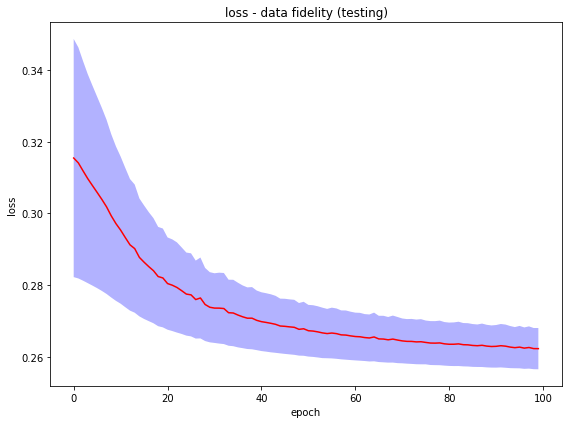


################################################################################
#
# RESULT # 06
#
################################################################################



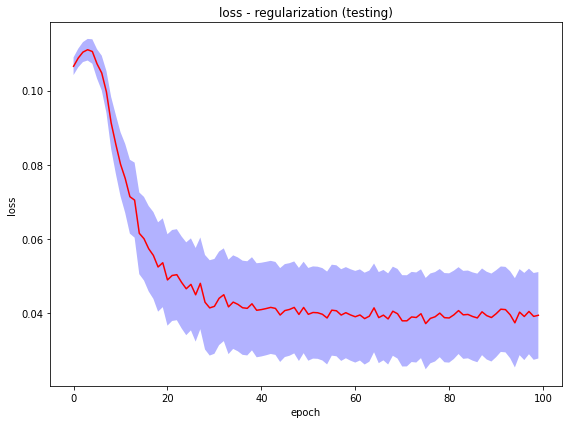


################################################################################
#
# RESULT # 07
#
################################################################################



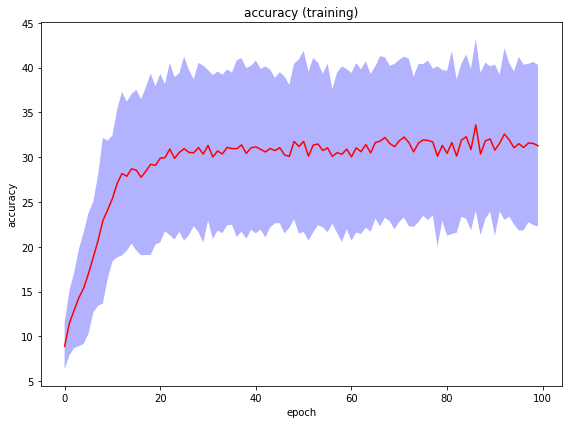


################################################################################
#
# RESULT # 08
#
################################################################################



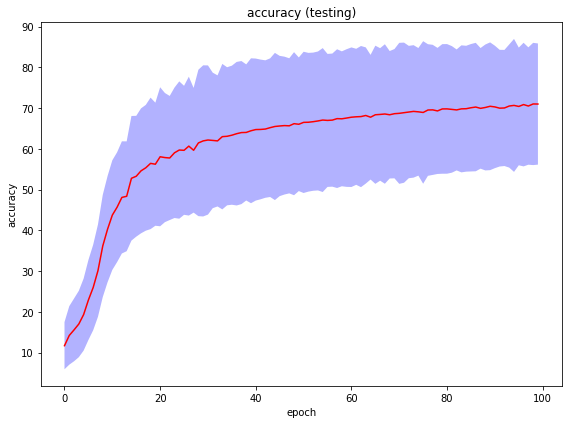


################################################################################
#
# RESULT # 09
#
################################################################################



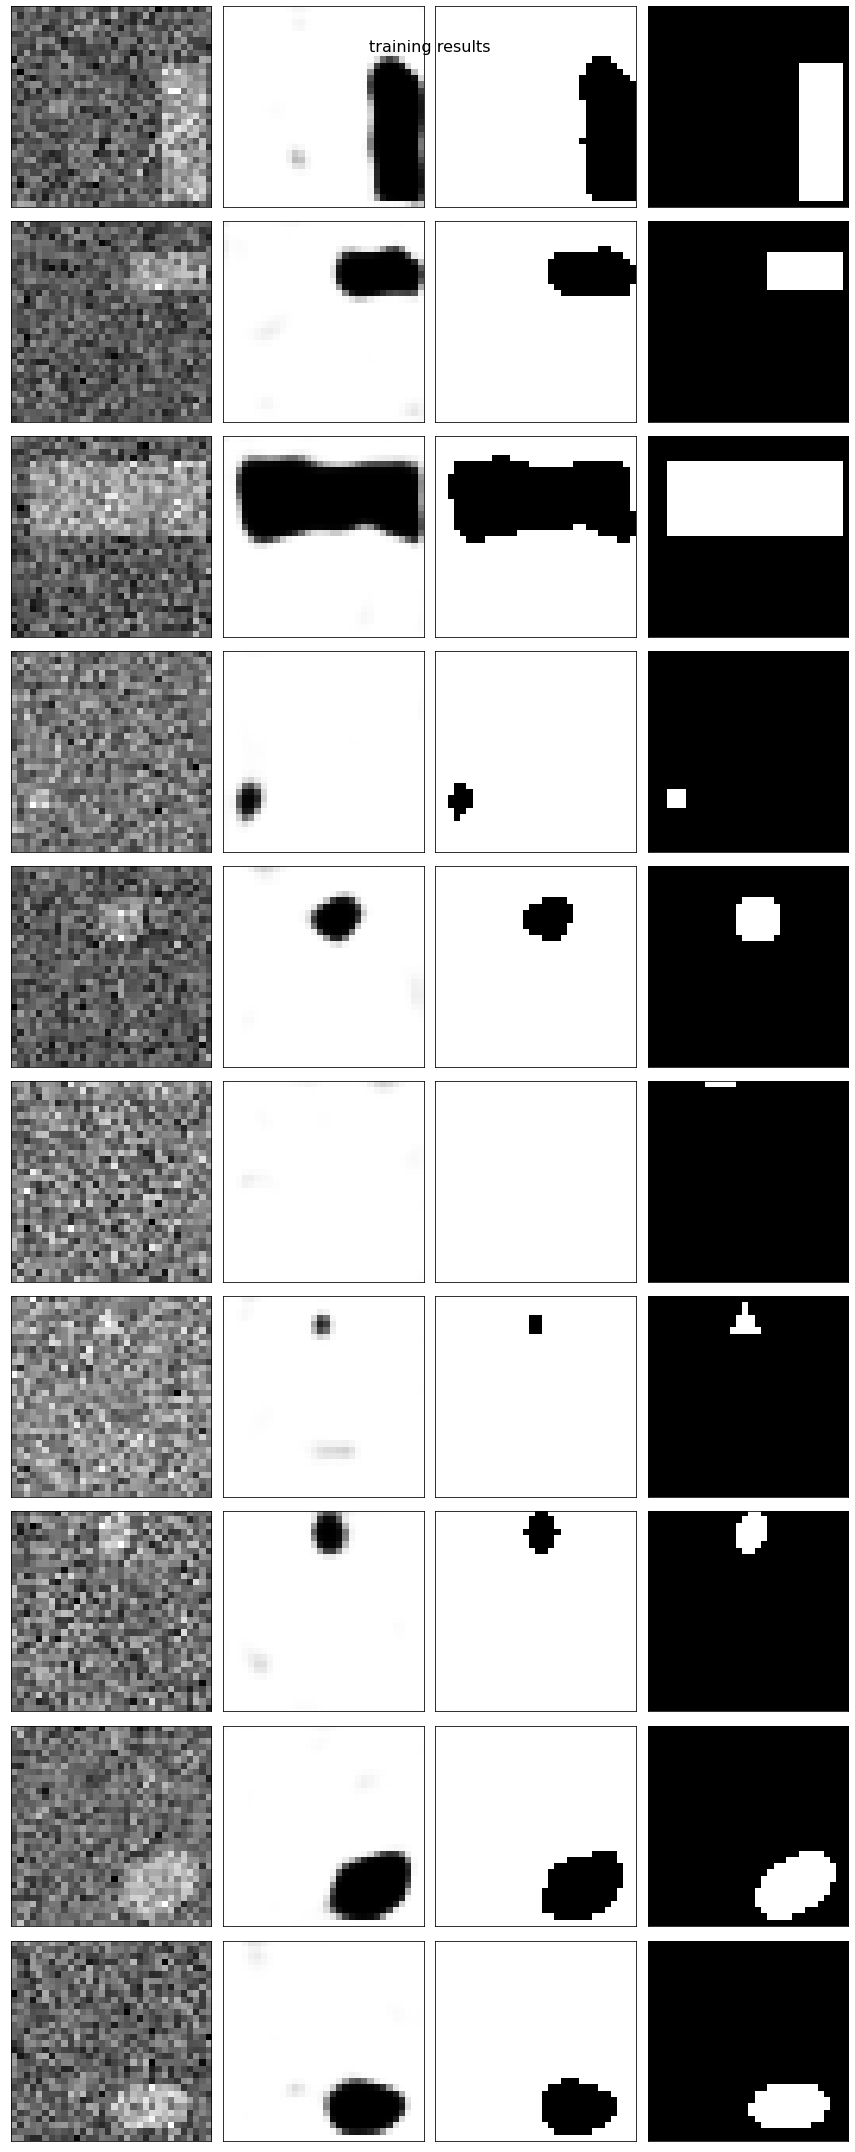


################################################################################
#
# RESULT # 10
#
################################################################################



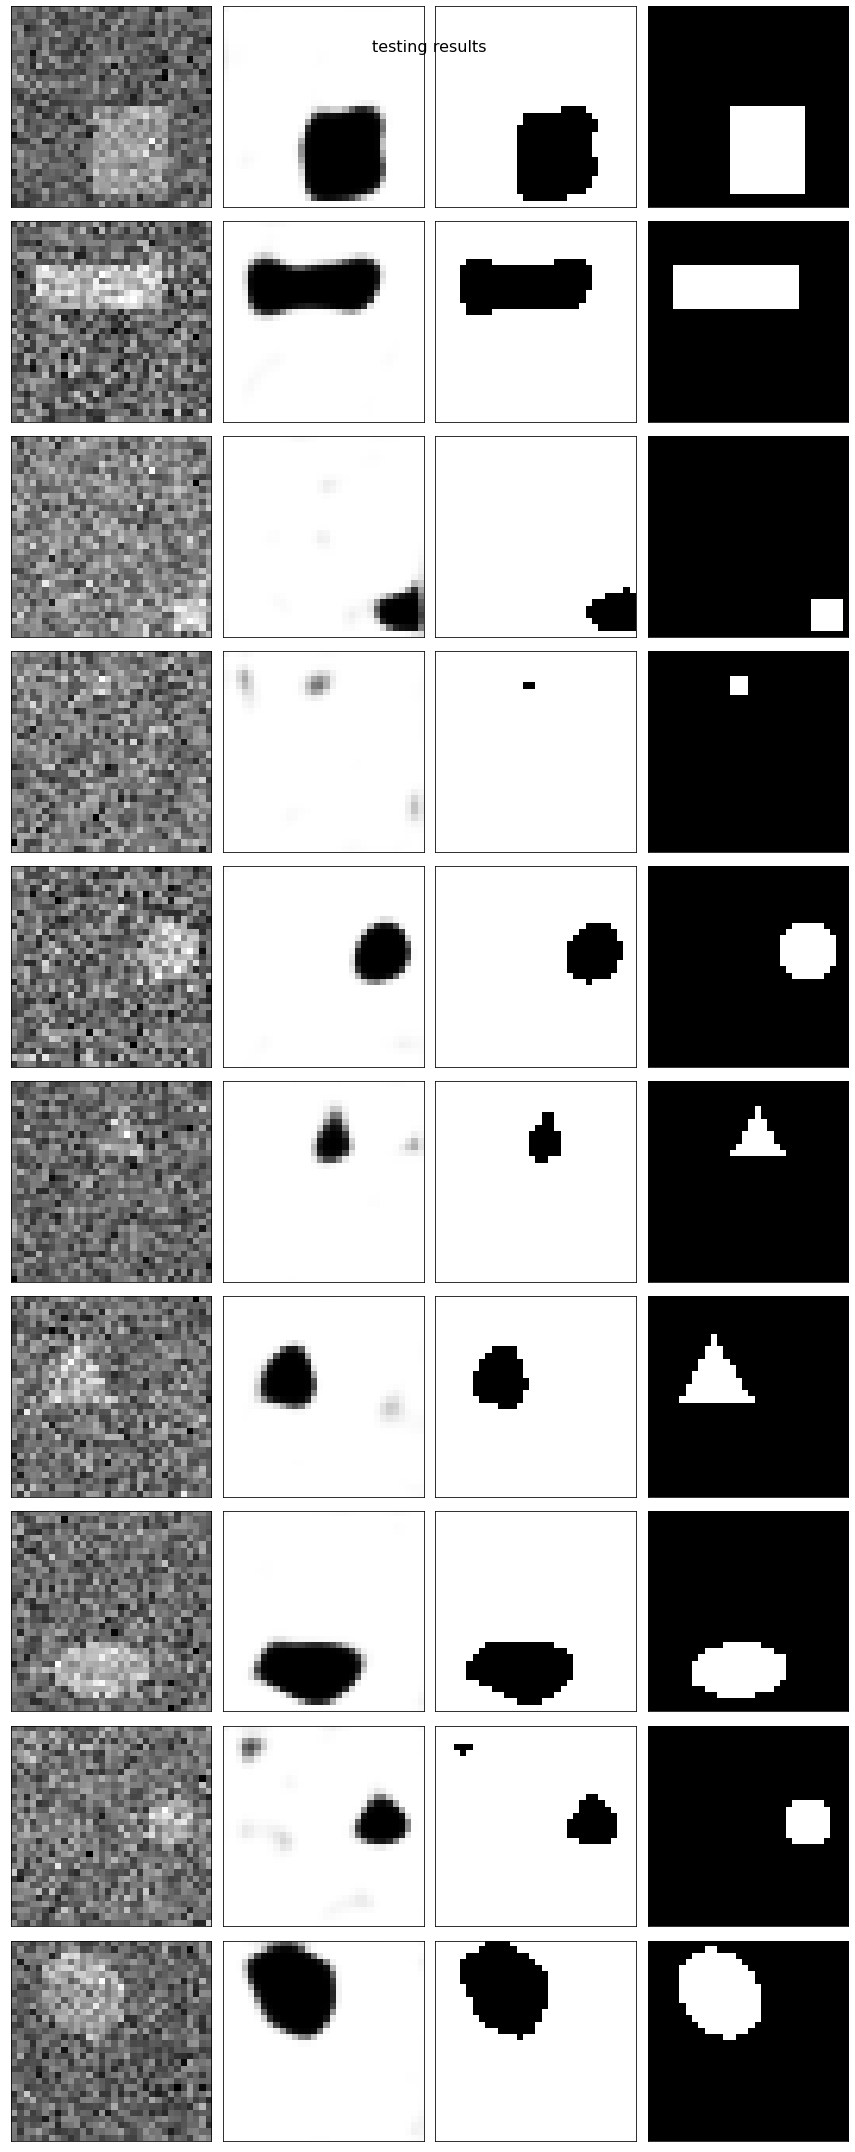


################################################################################
#
# RESULT # 11
#
################################################################################

final training accuracy = 31.27566147

################################################################################
#
# RESULT # 12
#
################################################################################

final testing accuracy = 70.98708344


In [117]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [118]:
!apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [119]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_10.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_10.ipynb to PDF
[NbConvertApp] Support files will be in assignment_10_files/
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Writing 111008 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 130908 bytes to /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_10.pdf
